In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm as normal, binom
import bplot as bp
from scipy.optimize import minimize
from scipy.special import loggamma
import patsy
from joblib import Parallel, delayed

In [4]:
def ll_normal(beta, yX):
    y = yX[:, 0]
    X = yX[:, 1:]
    N = X.shape[0]
    mu = np.full(N, np.nan)
    for n in range(N):
        mu[n] = np.sum(X[n, :] * beta)
        
    d = y - mu
    return np.sum(d*d)

def optim(data, initval = None):
    k = data.shape[1]-1
    return minimize(ll_normal, (initval if initval else np.random.normal(size = k)), args=(data), method="BFGS")["x"]

def bootstrap(data, R, fun):
    N, k = data.shape
    k -= 1
    thetas = np.full((R, k), np.nan)
    for r in range(R):
        idx = np.random.choice(N, N, replace=True)
        thetas[r, :] = fun(data[idx, :])
    return thetas

# 13 November, 2019

We are going to be using joblib library to parrallelize the bootstrap method to make it run faster.

## New Model -- Simple Linear Regression

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/master/possum.csv")

### Building off the two sample mean model
$$Y_n\sim N(\mu_n,\sigma^2)$$
We decided that the mean should be represented by
$$\mu_n=\beta_0+\beta_1*x_n$$ 
Which displays an offset from a base sample group.

The only thing that will change, is taking the categorical X-axis variable and making it numeric.  
So if we had a new plot, we would have numeric variables on both the X-axis and Y-axis. We are going to attempt to place a **best fitting** line through this data. Where we can state the mean for any given variable based off the function of the line.

We often think of the variable on the X-axis as **explanatory**.

For instance, in our possoms, we can allow age to explain lengths.

The lengths (on the Y-axis) would be the **response**

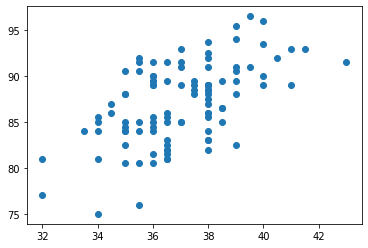

In [9]:
##Using Total Length and Tail Length
bp.point(df['tailL'], df['totalL'])

In [12]:
X = patsy.dmatrix("~ tailL", data=df)
yX = np.c_[df['totalL'],X]

In [13]:
X[:5, :]

array([[ 1. , 36. ],
       [ 1. , 36.5],
       [ 1. , 39. ],
       [ 1. , 38. ],
       [ 1. , 36. ]])

The design matrix holds the same logic as previous -- the intercept ($\beta_0$) and a column of every value that $x_n$ might take on. This is the same logic we've had previously, just $x_n$ is no longer just 1's and 0's, it's the true values as it corresponds to the X-axis

Our goal is to find the line that cuts through the data the best. We need to find the estimates for the intercept and the slope $\beta_0$ and $\beta_1$ respectively. 

github.com/roualdes/interactivestatistics -- An interactive web page to attempt to help explain models.

**Line of best fit** We are interested in the line that finds the minimum squared distance to each observation

Using all the data points in X, and all the points in Y, we are looking for two parameters.

In [14]:
optim(yX)

array([41.03721823,  1.24430483])

#### The Y intercept: 41.0 cm
When tail length is equal to 0cm, total length of a possum is expected to be 41.0cm.

#### The Slope:
Run first, then rise. As the explanatory variable increases, we can see an observation in the response.  
For our example:  
For every 1cm increase in tail length, we expect total length of possums to increase by 1.2cm

Due to the fact that the units on the X axis will cancel, we can compare any values to other values regardless of units.

Our intercept ($\beta_0$) will often be weird and incorrect (often negative) due to the fact that we don't have any/many observations of low end variables.

In [15]:
betas = bootstrap(yX, 1001, optim)

/home/ramsfield/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/ramsfield/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/ramsfield/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [16]:
np.percentile(betas, [10,90], axis=0)

array([[33.32832607,  1.03171948],
       [49.16143996,  1.44729033]])

We are 80% certain that the true total length of a possum without a tail (or tail length of 0cm) is between 33.33cm and 49.16cm.  
We are 80% certain that for every 1cm of tail length of a possum, the total length increases between 1.03cm and 1.45cm.

**Extrapolation** - Predict outside of the range of data. For instance, we *extrapolate* the data of when the tail length is 0 even though we have no observations of it. Extrapolation is dangerous due to the fact that they aren't reliable, but they're what we want, most of the time (extrapolate stock market increases)

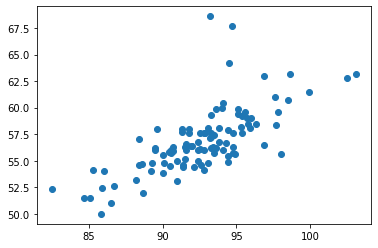

In [19]:
bp.point(df['headL'], df['skullW'])

In [20]:
X = patsy.dmatrix("~ headL", data=df)
yX = np.c_[df['skullW'],X]

In [21]:
optim(yX)

array([-0.46826597,  0.61933189])

In [22]:
betas = bootstrap(yX, 1001, optim)

/home/ramsfield/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/ramsfield/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/ramsfield/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/ramsfield/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [23]:
np.percentile(betas, [10,90], axis=0)

array([[-5.77609299,  0.56275492],
       [ 4.73684885,  0.67855795]])